In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.layers import Dropout

from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

In [2]:
#specify T-shape and #output levels

Tshape='80percent_Tshape'
levels='_11levels'

In [3]:
#training data 

train_df = pd.read_csv(Tshape+'_train_split70_30.csv')
print(train_df.head())
print(len(train_df))

   battery  timestep         RUL         age  capacity  current  resistance  \
0      463         0  100.516944  500.000000  2.081500     11.7    0.015400   
1      463         1   99.516944  504.181743  2.079480     -4.3    0.015412   
2      463         2   98.516944  507.979037  2.077646     -4.3    0.015422   
3      463         3   97.516944  513.403760  2.075026     -4.3    0.015438   
4      463         4   96.516944  517.491086  2.073052     -4.3    0.015449   

          SOC   voltage  event  
0  100.000000  3.584200      1  
1   36.930727  3.247362      1  
2   55.426200  3.541408      1  
3   65.716753  3.265449      1  
4   45.349198  3.539159      1  
14282


In [4]:

#Dropping rows with RUL =0, since we use log(RUL)

id0=train_df[train_df['RUL'] == 0].index
train_df1=train_df.drop(index=id0)
print(len(train_df))
print(len(train_df1))


14282
14002


In [5]:
#testing set 

test_df = pd.read_csv('RUL_test_split70_30.csv')
test_df['event'] = [1]*len(test_df) #no censoring, thus event=1
print(len(test_df))
test_df.head()

11016


,battery,timestep,RUL,age,capacity,current,resistance,SOC,voltage,event
0,254,0,68.183611,500.000000,2.081500,11.7,0.015400,100.000000,3.584200,1
1,254,1,67.183611,504.177396,2.079482,-4.3,0.015412,52.003613,3.540539,1
2,254,2,66.183611,511.981016,2.075713,-4.3,0.015434,19.119632,3.530015,1
3,254,3,65.183611,519.753577,2.071959,11.7,0.015455,43.710397,3.253310,1
4,254,4,64.183611,523.639026,2.070082,11.7,0.015466,75.199604,3.547933,1


In [6]:
##combine train and test data 

df=pd.concat([train_df1,test_df], axis=0)
print(len(df))
df.describe()

25018


,battery,timestep,RUL,age,capacity,current,resistance,SOC,voltage,event
count,25018.000000,25018.000000,25018.000000,25018.000000,25018.000000,25018.000000,25018.000000,25018.000000,25018.000000,25018.000000
mean,262.741066,31.061716,31.701724,689.941853,1.989758,0.201079,0.015932,51.055840,3.461104,0.666720
std,142.958345,24.351696,24.234235,138.758581,0.067020,7.194416,0.000389,23.303741,0.135669,0.471395
min,1.000000,0.000000,0.000278,500.000000,1.843639,-4.300000,0.015400,0.999962,2.637006,0.000000
25%,141.000000,12.000000,13.000000,573.815065,1.938266,-4.300000,0.015607,32.819135,3.270765,0.000000
50%,268.000000,25.000000,25.916944,657.693517,2.005334,-4.300000,0.015842,50.940056,3.539271,1.000000
75%,390.000000,47.000000,47.346111,796.551455,2.045847,11.700000,0.016230,68.985754,3.545520,1.000000
max,500.000000,166.000000,166.266944,992.465737,2.081500,11.700000,0.016779,100.000000,3.724428,1.000000


In [7]:
##input data is scaled into [-1,1]

X = df.values[:,3:9]
y = df.values[:,2]


scaler = MinMaxScaler(feature_range=(-1, 1))


# transform data
X_scaled = scaler.fit_transform(X)


#checking results
print(pd.DataFrame(X_scaled).describe())
X_scaled.shape


                  0             1             2             3             4  \
count  25018.000000  25018.000000  25018.000000  25018.000000  25018.000000   
mean      -0.228609      0.228609     -0.437365     -0.228609      0.011229   
std        0.563526      0.563526      0.899302      0.563526      0.470782   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -0.700223     -0.204354     -1.000000     -0.700223     -0.357189   
50%       -0.359576      0.359576     -1.000000     -0.359576      0.008890   
75%        0.204354      0.700223      1.000000      0.204354      0.373450   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                  5  
count  25018.000000  
mean       0.515691  
std        0.249525  
min       -1.000000  
25%        0.165618  
50%        0.659457  
75%        0.670952  
max        1.000000  


(25018, 6)

In [8]:
#training scaled data

n=len(train_df1)
X_train_scaled = X_scaled[0:n,:]
y_train = y[0:n]
print(X_train_scaled.shape)
print(y_train.shape)

#testing scaled data
X_test_scaled = X_scaled[n:,:]
y_test = y[n:]
print(X_test_scaled.shape)
print(y_test.shape)



(14002, 6)
(14002,)
(11016, 6)
(11016,)


In [9]:
## Quantile lSTM



C1, C2 = tf.constant(1.0, dtype='float32'), tf.constant(10.0, dtype="float32")

num_features = X_train_scaled.shape[1] # 6

#quantile levels

#qs = [0.05, 0.25, 0.50, 0.75,0.95] #5levels

qs = [0.05, 0.1, 0.2, 0.3, 0.4, 0.50,0.6, 0.7,0.8,0.9,0.95] #11levels

#qs = [0.01,0.05, 0.1, 0.2, 0.3, 0.4, 0.50,0.6, 0.7,0.8,0.9,0.95,0.99] #13levels
#qs = [0.01,0.025,0.05, 0.1, 0.2, 0.3, 0.4, 0.50,0.6, 0.7,0.8,0.9,0.95,0.975,0.99] #15levels
#qs = [0.01,0.025,0.05, 0.1,0.15,0.2,0.25, 0.3,0.35, 0.4,0.45, 0.50, 0.55,0.6,0.65, 0.7, 0.75,0.8,0.85,0.9,0.95,0.975, 0.99] #23 levels

num_out = len(qs)



def winkler_score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    Up = y_pred[:, 10]
    Lo = y_pred[:, 0]
    Delta =  tf.subtract(Up , Lo ) #Q95% - Q5%
    #rul_pred = y_pred[:, 5] #median 
    
    alpha = 0.1
    condition1 = tf.greater(Lo, tf.transpose(y_true[:,0]))
    condition2 = tf.greater(tf.transpose(y_true[:,0]), Up)
    metric = tf.where(condition1, Delta + 2*(Lo-y_true[:,0])/alpha, tf.where(condition2,Delta + 2*(y_true[:,0]-Up)/alpha,Delta ))
    
    return K.mean(metric)

#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

#Kaplan-Meier weights   
def get_weights(time, delta,num_out):
    kmf = KaplanMeierFitter()
    kmf.fit(durations = time, event_observed = 1-delta,timeline=time )#timeline=time
    km = np.array(kmf.survival_function_.KM_estimate)
    km[km == 0] = 0.005
    w = np.array(delta/km)
    ww= np.transpose([w]*num_out)
    return ww

#============================#
def weight_qloss(y_true, y_pred, weights):
    # weighted pinball loss for multiple quantiles
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    w=tf.dtypes.cast(weights, tf.float32)
    e = w*e
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

#define model
def make_model():

    z = L.Input((num_features,),name="input") 
    true = L.Input((num_out,))
    weights = L.Input((num_out,))
    y = L.LSTM(300, return_sequences=True,dropout=0.0, recurrent_dropout=0.25)(tf.expand_dims(z, axis=-1))# 300 is number of hidden nodes
    y = L.Reshape([300*num_features])(y)
    x = L.Dense(100, activation="relu", name="d1")(y)
    x = L.BatchNormalization()(x)
    x = L.Dropout(0.25)(x)
    x = L.GaussianNoise(stddev=0.3)(x)

    x = L.Dense(100, activation="relu", name="d2")(x)
    x = L.BatchNormalization()(x)
    x = L.Dropout(0.25)(x)
    x = L.GaussianNoise(stddev=0.3)(x)

    p1 = L.Dense(num_out, activation="softplus", name="p1")(x)
    p2 = L.Dense(1, activation="linear", name="p2")(x)
    preds = L.Lambda(lambda x:  tf.cumsum(x[0], axis=1)+x[1], name="preds")([p1, p2])
    
    model = M.Model([z,true,weights], preds, name="MNQ-LSTM")
    model.add_loss(weight_qloss(true, preds, weights))
    model.compile(loss=None, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.005, amsgrad=False))
 
    return model

In [10]:
## measures for model evaluation


def get_mse(obsT, predT, event):
    temp = np.multiply(event, (obsT-predT)**2)
    mse = np.sum(temp)/np.sum(event)
    return mse

def get_rmse(obsT, predT, event):
    temp = np.multiply(event, (obsT-predT)**2)
    mse = np.sum(temp)/np.sum(event)
    rmse = np.sqrt(mse)
    return rmse

def get_mae(obsT, predT, event):
    temp = np.multiply(event, abs(obsT-predT))
    mae = np.sum(temp)/np.sum(event)
    return mae

def get_ci(obsT, predT, event):
    ci = concordance_index(obsT,predT,event)
    return ci

def r2_keras(y_true, y_pred, event):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(event*K.square( y_true - y_pred ))
    mu= K.sum(y_true)/K.sum(event)
    SS_tot = K.sum(event*K.square( y_true - mu ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def check_crossing(pred_df):
    
    n=pred_df.shape[1]
    
    for i in range(n-1):
        j=i+1
        s= sum(pred_df.iloc[:,i] >= pred_df.iloc[:,j])
        
        if s!=0:
            print('Has crossing at:', (i,j))
        else:
            print('Has no crossing at:', (i,j))
            

In [11]:
#take log output

y_train_log = np.transpose([np.log(y_train)]*num_out)
print(y_train_log)
print(y_train_log.shape)

[[ 4.61032631  4.61032631  4.61032631 ...  4.61032631  4.61032631
   4.61032631]
 [ 4.60032793  4.60032793  4.60032793 ...  4.60032793  4.60032793
   4.60032793]
 [ 4.59022856  4.59022856  4.59022856 ...  4.59022856  4.59022856
   4.59022856]
 ...
 [ 0.88250412  0.88250412  0.88250412 ...  0.88250412  0.88250412
   0.88250412]
 [ 0.34850275  0.34850275  0.34850275 ...  0.34850275  0.34850275
   0.34850275]
 [-0.87480229 -0.87480229 -0.87480229 ... -0.87480229 -0.87480229
  -0.87480229]]
(14002, 11)


In [12]:

################ In case 0% T-shape, using these weights #################

# weights = np.ones((len(y_train_log), num_out)) #not taking T-shape into account, so weights = 1
# print(weights.shape)

In [13]:
##K-M weights in case having T-shape 

weights = get_weights(train_df1.loc[:,'RUL'], train_df1.loc[:,'event'], num_out) #Kaplan-Meier Weights
print(weights.shape)

(14002, 11)


In [14]:
#Summarize the desiged model

model=make_model()
print(model.summary())

Model: "MNQ-LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 6)]          0           []                               
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, 6, 1)         0           ['input[0][0]']                  
                                                                                                  
 lstm (LSTM)                    (None, 6, 300)       362400      ['tf.expand_dims[0][0]']         
                                                                                                  
 reshape (Reshape)              (None, 1800)         0           ['lstm[0][0]']                   
                                                                                           

In [15]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('quantile_model_'+Tshape+levels+'_split70_30.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

BATCH_SIZE= 128

# fit model

from datetime import datetime

start = datetime.now()
#history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), batch_size=BATCH_SIZE,epochs=30, verbose=0, callbacks=[es, mc])
history = model.fit([X_train_scaled, y_train_log,weights], y=None, validation_split=0.2, batch_size=BATCH_SIZE,epochs=100, verbose=0,callbacks=[es, mc])
end= datetime.now()

print("elapsed time (in minutes):",(end-start).total_seconds()/60 )


Epoch 1: val_loss improved from inf to 0.42285, saving model to quantile_model_80percent_Tshape_11levels_split70_30.h5

Epoch 2: val_loss improved from 0.42285 to 0.26502, saving model to quantile_model_80percent_Tshape_11levels_split70_30.h5

Epoch 3: val_loss improved from 0.26502 to 0.25427, saving model to quantile_model_80percent_Tshape_11levels_split70_30.h5

Epoch 4: val_loss improved from 0.25427 to 0.14840, saving model to quantile_model_80percent_Tshape_11levels_split70_30.h5

Epoch 5: val_loss did not improve from 0.14840

Epoch 6: val_loss improved from 0.14840 to 0.14111, saving model to quantile_model_80percent_Tshape_11levels_split70_30.h5

Epoch 7: val_loss improved from 0.14111 to 0.12938, saving model to quantile_model_80percent_Tshape_11levels_split70_30.h5

Epoch 8: val_loss improved from 0.12938 to 0.11521, saving model to quantile_model_80percent_Tshape_11levels_split70_30.h5

Epoch 9: val_loss did not improve from 0.11521

Epoch 10: val_loss did not improve from

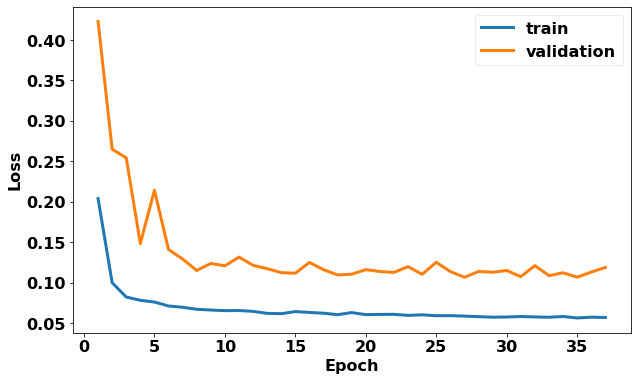

In [16]:
# plot training history
f = plt.figure(figsize=(10, 6))
#f.set_rasterized(True)
plt.rc('font', size=16, weight='bold')  

ax = plt.axes()
ax.set_facecolor("white")
#ax.set_rasterized(True)
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
plt.rcParams["figure.autolayout"] = True
plt.style.use('ggplot')

ep=list(np.arange(len(history.history['loss']))+1)
plt.plot(ep,history.history['loss'], label='train', lw=3)
plt.plot(ep,history.history['val_loss'], label='validation', lw=3)
plt.xlabel('Epoch', weight='bold')
plt.ylabel('Loss', weight='bold')
plt.legend(loc="best",facecolor="white",prop={'size': 16})
f.savefig('loss_'+Tshape+levels+'_split70_30.png',dpi=500)
plt.show()

In [17]:
#save training loss

loss=pd.DataFrame(history.history['loss'])
loss_val=pd.DataFrame(history.history['val_loss'])
loss.to_csv('loss_'+Tshape+levels+'_split70_30.csv', index=False)
loss_val.to_csv('loss_val_'+Tshape+levels+'_split70_30.csv', index=False)
loss.describe()

,0
count,37.000000
mean,0.067766
std,0.024593
min,0.056543
25%,0.058398
50%,0.061022
75%,0.065763
max,0.204125


In [18]:

#load and save the best trained model

from tensorflow import keras

model_s = keras.models.load_model('quantile_model_'+Tshape+levels+'_split70_30.h5', custom_objects={"loss": weight_qloss})
model_s.save('best_MNQ_LSTM_'+Tshape+levels+'_split70_30.h5')


In [19]:
#Make predictions on testing data

final_model= M.Model(model_s.input[0], model_s.output)
pred= final_model.predict(X_test_scaled, batch_size=BATCH_SIZE, verbose=0) #log scale
pred_rul=np.exp(pred) #original scale 


In [20]:
#save predicted values for later use

print(pred.shape)

pred_test=pd.DataFrame(pred)
pred_test.to_csv('log_rul_pred_test_'+Tshape+levels+'_split70_30.csv', index=False)

(11016, 11)


In [21]:
#check crossing 

check_crossing(pred_test)

Has no crossing at: (0, 1)
Has no crossing at: (1, 2)
Has no crossing at: (2, 3)
Has no crossing at: (3, 4)
Has no crossing at: (4, 5)
Has no crossing at: (5, 6)
Has no crossing at: (6, 7)
Has no crossing at: (7, 8)
Has no crossing at: (8, 9)
Has no crossing at: (9, 10)


In [22]:
#evaluate model in testing data

col=int((len(qs)-1)/2) #median column

event1= np.ones((len(y_test)))
rmse=get_rmse(np.log(y_test), pred[:,col], event1)
mae=get_mae(np.log(y_test), pred[:,col], event1)

ci = get_ci(np.log(y_test), pred[:,col], event1)
r2 = r2_keras(np.log(y_test), pred[:,col], event1)

y_test_log = np.transpose([np.log(y_test)]*num_out)
q_score = qloss(y_test_log, pred) 
print('RMSE:', rmse, 'MAE:', mae, 'Q-score:', np.array(q_score), 'r2_index:', np.array(r2),'Concordance index:', ci)


RMSE: 0.24054088522790532 MAE: 0.13423700922609075 Q-score: 0.054695986 r2_index: 0.9463800614954913 Concordance index: 0.9286071130664834
